In [1]:
using JLD2, CairoMakie, StatsBase
using Jchemo, JchemoData

In [2]:
using JchemoData, JLD2, CairoMakie
path_jdat = dirname(dirname(pathof(JchemoData)))
db = joinpath(path_jdat, "data/cassav.jld2")
@load db dat
pnames(dat)

(:X, :Y)

In [3]:
X = dat.X
y = dat.Y.tbc
year = dat.Y.year

280-element Vector{Int64}:
 2009
 2009
 2009
 2009
 2009
 2009
 2009
 2009
 2009
 2009
    ⋮
 2013
 2013
 2013
 2013
 2013
 2013
 2013
 2013
 2013

In [4]:
wl = names(X)
wl_num = parse.(Float64, wl)

1050-element Vector{Float64}:
  400.0
  402.0
  404.0
  406.0
  408.0
  410.0
  412.0
  414.0
  416.0
  418.0
    ⋮
 2482.0
 2484.0
 2486.0
 2488.0
 2490.0
 2492.0
 2494.0
 2496.0
 2498.0

In [5]:
tab(year)

OrderedCollections.OrderedDict{Int64, Int64} with 5 entries:
  2009 => 42
  2010 => 47
  2011 => 40
  2012 => 71
  2013 => 80

In [6]:
s = year .<= 2012
Xtrain = X[s, :]
ytrain = y[s]
Xtest = rmrow(X, s)
ytest = rmrow(y, s)
ntrain = nro(Xtrain)
ntest = nro(Xtest)
ntot = ntrain + ntest
(ntot = ntot, ntrain, ntest)

(ntot = 280, ntrain = 200, ntest = 80)

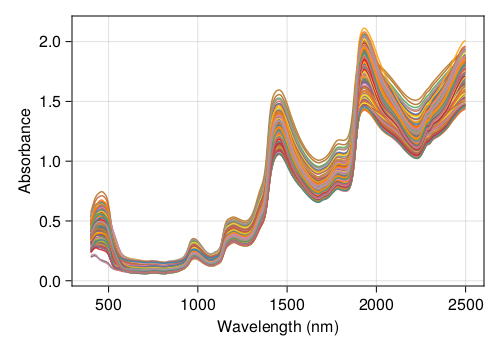

In [7]:
plotsp(X, wl_num;
    xlabel = "Wavelength (nm)", ylabel = "Absorbance").f

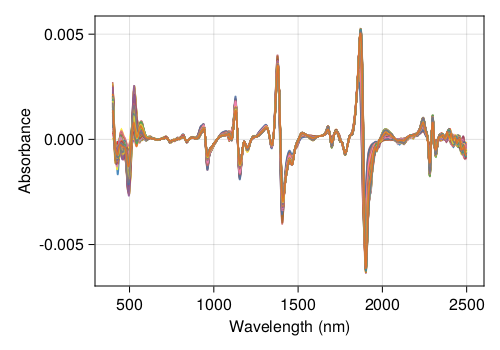

In [8]:
f = 15 ; pol = 3 ; d = 2
Xp = savgol(snv(X); f = f, pol = pol, d = d)

plotsp(Xp, wl_num;
    xlabel = "Wavelength (nm)", ylabel = "Absorbance").f

In [9]:
nval = Int64(round(.30 * ntrain))
s = sampsys(ytrain; k = nval).train
ytrain[s]
Xcal = rmrow(Xtrain, s)
ycal = rmrow(ytrain, s)
Xval = Xtrain[s, :]
yval = ytrain[s, :]
ncal = ntrain - nval
(ntot = ntot, ntrain, ntest, ncal, nval)

(ntot = 280, ntrain = 200, ntest = 80, ncal = 140, nval = 60)

In [10]:
# PLSR
nlv = 0:40
res = gridscorelv(Xcal, ycal, Xval, yval;
    score = rmsep, fun = plskern, nlv = nlv)

Row,nlv,y1
,Int64,Float64
1,0,3.05343
2,1,2.75697
3,2,2.28919
4,3,2.19068
5,4,1.05577
6,5,0.980032
7,6,0.85428
8,7,0.81996
9,8,0.875437


In [11]:
u = findall(res.y1 .== minimum(res.y1))[1]
res[u, :]

Row,nlv,y1
,Int64,Float64
13,12,0.801786


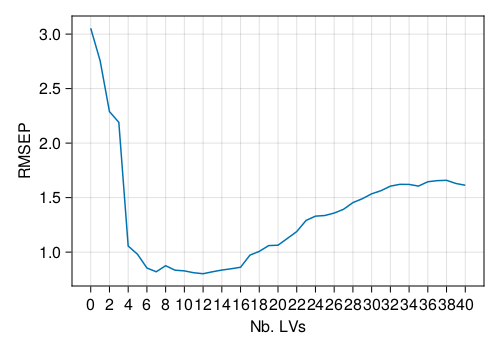

In [12]:
plotgrid(res.nlv, res.y1; step = 2,
    xlabel = "Nb. LVs", ylabel = "RMSEP").f

In [13]:
fm = plskern(Xtrain, ytrain; nlv = res.nlv[u]) ;
pred = Jchemo.predict(fm, Xtest).pred ;
@show rmsep(pred, ytest)
mse(pred, ytest)

rmsep(pred, ytest) = [1.5373184736097893;;]


Row,nam,msep,rmsep,sep,bias,cor2,r2,rpd,rpdr,mean
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,y1,2.363,1.537,1.097,-1.077,0.949,0.836,2.467,3.017,8.496


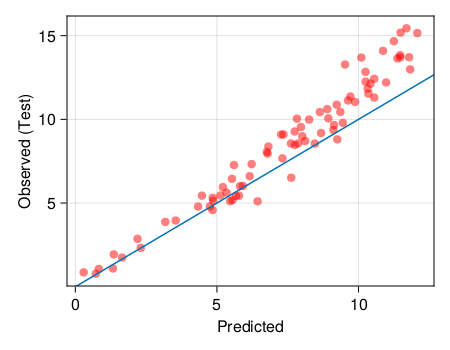

In [14]:
f, ax = plotxy(vec(pred), ytest; color = (:red, .5),
    xlabel = "Predicted", ylabel = "Observed (Test)",
    resolution = (450, 350))
ablines!(ax, 0, 1)
f

In [15]:
# LWMLR-S with a PCA-score space = "LWR" (Naes et al.1990)
metric = ["eucl", "mahal"]
h = [1; 2; 6] ; k = [50; 100; 150]
nlv = Int64.(LinRange(5, 20, 4))
reduc = ["pca"]
pars = mpar(metric = metric, h = h, k = k,
    nlv = nlv, reduc = reduc)
length(pars[1])

72

In [16]:
res = gridscore(Xcal, ycal, Xval, yval;
    score = rmsep, fun = lwmlr_s, pars = pars,
    verbose = true)

-- Nb. combinations = 72
:metric => "eucl":h => 1:k => 50:nlv => 5:reduc => "pca"
:metric => "mahal":h => 1:k => 50:nlv => 5:reduc => "pca"
:metric => "eucl":h => 2:k => 50:nlv => 5:reduc => "pca"
:metric => "mahal":h => 2:k => 50:nlv => 5:reduc => "pca"
:metric => "eucl":h => 6:k => 50:nlv => 5:reduc => "pca"
:metric => "mahal":h => 6:k => 50:nlv => 5:reduc => "pca"
:metric => "eucl":h => 1:k => 100:nlv => 5:reduc => "pca"
:metric => "mahal":h => 1:k => 100:nlv => 5:reduc => "pca"
:metric => "eucl":h => 2:k => 100:nlv => 5:reduc => "pca"
:metric => "mahal":h => 2:k => 100:nlv => 5:reduc => "pca"
:metric => "eucl":h => 6:k => 100:nlv => 5:reduc => "pca"
:metric => "mahal":h => 6:k => 100:nlv => 5:reduc => "pca"
:metric => "eucl":h => 1:k => 150:nlv => 5:reduc => "pca"
:metric => "mahal":h => 1:k => 150:nlv => 5:reduc => "pca"
:metric => "eucl":h => 2:k => 150:nlv => 5:reduc => "pca"
:metric => "mahal":h => 2:k => 150:nlv => 5:reduc => "pca"
:metric => "eucl":h => 6:k => 150:nlv => 5:re

Row,metric,h,k,nlv,reduc,y1
,Any,Any,Any,Any,Any,Float64
1,eucl,1,50,5,pca,1.16887
2,mahal,1,50,5,pca,1.24864
3,eucl,2,50,5,pca,1.16232
4,mahal,2,50,5,pca,1.22718
5,eucl,6,50,5,pca,1.16212
6,mahal,6,50,5,pca,1.22216
7,eucl,1,100,5,pca,1.10752
8,mahal,1,100,5,pca,1.23106
9,eucl,2,100,5,pca,1.09471


In [17]:
u = findall(res.y1 .== minimum(res.y1))[1]
res[u, :]

Row,metric,h,k,nlv,reduc,y1
,Any,Any,Any,Any,Any,Float64
70,mahal,2,150,20,pca,0.78213


In [18]:
fm = lwmlr_s(Xtrain, ytrain; metric = res.metric[u],
    h = res.h[u], k = res.k[u], nlv = res.nlv[u],
    reduc = res.reduc[u]) ;
pred = Jchemo.predict(fm, Xtest).pred
@show rmsep(pred, ytest)
mse(pred, ytest)

rmsep(pred, ytest) = [1.5158702643408855;;]


Row,nam,msep,rmsep,sep,bias,cor2,r2,rpd,rpdr,mean
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,y1,2.298,1.516,1.207,-0.917,0.92,0.84,2.501,4.004,8.496


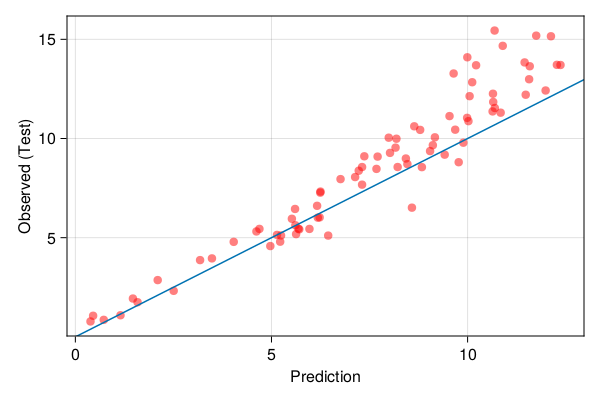

In [19]:
plotxy(vec(pred), ytest; color = (:red, .5),
    bisect = true, xlabel = "Prediction",
    ylabel = "Observed (Test)").f

In [20]:
# LWMLR-S with a PLS-score space
metric = ["eucl", "mahal"]
h = [1; 2; 6] ; k = [50; 100; 150]
nlv = Int64.(LinRange(5, 20, 4))
reduc = ["pls"]
pars = mpar(metric = metric, h = h, k = k,
    nlv = nlv, reduc = reduc)
length(pars[1])

72

In [21]:
res = gridscore(Xcal, ycal, Xval, yval;
    score = rmsep, fun = lwmlr_s, pars = pars,
    verbose = true)

-- Nb. combinations = 72
:metric => "eucl":h => 1:k => 50:nlv => 5:reduc => "pls"
:metric => "mahal":h => 1:k => 50:nlv => 5:reduc => "pls"
:metric => "eucl":h => 2:k => 50:nlv => 5:reduc => "pls"
:metric => "mahal":h => 2:k => 50:nlv => 5:reduc => "pls"
:metric => "eucl":h => 6:k => 50:nlv => 5:reduc => "pls"
:metric => "mahal":h => 6:k => 50:nlv => 5:reduc => "pls"
:metric => "eucl":h => 1:k => 100:nlv => 5:reduc => "pls"
:metric => "mahal":h => 1:k => 100:nlv => 5:reduc => "pls"
:metric => "eucl":h => 2:k => 100:nlv => 5:reduc => "pls"
:metric => "mahal":h => 2:k => 100:nlv => 5:reduc => "pls"
:metric => "eucl":h => 6:k => 100:nlv => 5:reduc => "pls"
:metric => "mahal":h => 6:k => 100:nlv => 5:reduc => "pls"
:metric => "eucl":h => 1:k => 150:nlv => 5:reduc => "pls"
:metric => "mahal":h => 1:k => 150:nlv => 5:reduc => "pls"
:metric => "eucl":h => 2:k => 150:nlv => 5:reduc => "pls"
:metric => "mahal":h => 2:k => 150:nlv => 5:reduc => "pls"
:metric => "eucl":h => 6:k => 150:nlv => 5:re

Row,metric,h,k,nlv,reduc,y1
,Any,Any,Any,Any,Any,Float64
1,eucl,1,50,5,pls,1.07489
2,mahal,1,50,5,pls,1.1621
3,eucl,2,50,5,pls,1.05878
4,mahal,2,50,5,pls,1.13125
5,eucl,6,50,5,pls,1.05567
6,mahal,6,50,5,pls,1.12559
7,eucl,1,100,5,pls,1.01079
8,mahal,1,100,5,pls,1.11574
9,eucl,2,100,5,pls,0.998081


In [22]:
u = findall(res.y1 .== minimum(res.y1))[1]
res[u, :]

Row,metric,h,k,nlv,reduc,y1
,Any,Any,Any,Any,Any,Float64
28,mahal,2,100,10,pls,0.784083


In [23]:
fm = lwmlr_s(Xtrain, ytrain; metric = res.metric[u],
    h = res.h[u], k = res.k[u], nlv = res.nlv[u],
    reduc = res.reduc[u]) ;
pred = Jchemo.predict(fm, Xtest).pred
@show rmsep(pred, ytest)
mse(pred, ytest)

rmsep(pred, ytest) = [1.2144079252900708;;]


Row,nam,msep,rmsep,sep,bias,cor2,r2,rpd,rpdr,mean
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,y1,1.475,1.214,0.932,-0.779,0.956,0.897,3.122,4.403,8.496


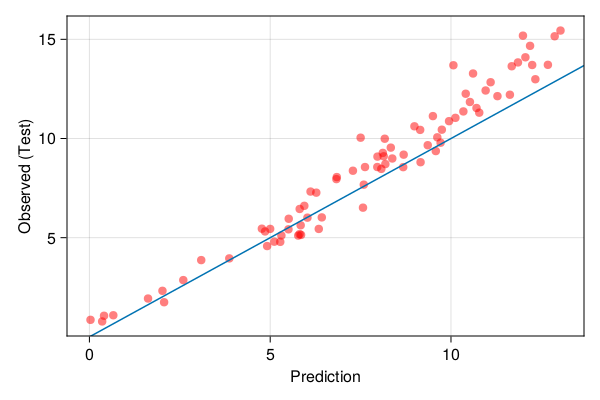

In [24]:
plotxy(vec(pred), ytest; color = (:red, .5),
    bisect = true, xlabel = "Prediction",
    ylabel = "Observed (Test)").f

In [25]:
# LWMLR-S with a DKPLS-score space
metric = ["eucl", "mahal"]
h = [1; 2; 6] ; k = [50; 100; 150]
nlv = Int64.(LinRange(5, 20, 4))
gamma = 10.0.^(-2:3)
reduc = ["dkpls"]
pars = mpar(metric = metric, h = h, k = k,
    nlv = nlv, gamma = gamma, reduc = reduc)
length(pars[1])

432

In [26]:
res = gridscore(Xcal, ycal, Xval, yval;
    score = rmsep, fun = lwmlr_s, pars = pars,
    verbose = true)

-- Nb. combinations = 432
:metric => "eucl":h => 1:k => 50:nlv => 5:gamma => 0.010000000000000002:reduc => "dkpls"
:metric => "mahal":h => 1:k => 50:nlv => 5:gamma => 0.010000000000000002:reduc => "dkpls"
:metric => "eucl":h => 2:k => 50:nlv => 5:gamma => 0.010000000000000002:reduc => "dkpls"
:metric => "mahal":h => 2:k => 50:nlv => 5:gamma => 0.010000000000000002:reduc => "dkpls"
:metric => "eucl":h => 6:k => 50:nlv => 5:gamma => 0.010000000000000002:reduc => "dkpls"
:metric => "mahal":h => 6:k => 50:nlv => 5:gamma => 0.010000000000000002:reduc => "dkpls"
:metric => "eucl":h => 1:k => 100:nlv => 5:gamma => 0.010000000000000002:reduc => "dkpls"
:metric => "mahal":h => 1:k => 100:nlv => 5:gamma => 0.010000000000000002:reduc => "dkpls"
:metric => "eucl":h => 2:k => 100:nlv => 5:gamma => 0.010000000000000002:reduc => "dkpls"
:metric => "mahal":h => 2:k => 100:nlv => 5:gamma => 0.010000000000000002:reduc => "dkpls"
:metric => "eucl":h => 6:k => 100:nlv => 5:gamma => 0.010000000000000002:re

Row,metric,h,k,nlv,gamma,reduc,y1
,Any,Any,Any,Any,Any,Any,Float64
1,eucl,1,50,5,0.01,dkpls,1.95776
2,mahal,1,50,5,0.01,dkpls,2.02716
3,eucl,2,50,5,0.01,dkpls,1.95039
4,mahal,2,50,5,0.01,dkpls,1.99556
5,eucl,6,50,5,0.01,dkpls,1.93484
6,mahal,6,50,5,0.01,dkpls,1.96894
7,eucl,1,100,5,0.01,dkpls,2.04985
8,mahal,1,100,5,0.01,dkpls,2.02927
9,eucl,2,100,5,0.01,dkpls,2.05018


In [27]:
u = findall(res.y1 .== minimum(res.y1))[1]
res[u, :]

Row,metric,h,k,nlv,gamma,reduc,y1
,Any,Any,Any,Any,Any,Any,Float64
68,mahal,1,150,20,0.01,dkpls,0.895641


In [28]:
fm = lwmlr_s(Xtrain, ytrain; metric = res.metric[u],
    h = res.h[u], k = res.k[u], nlv = res.nlv[u],
    gamma = res.gamma[u], reduc = res.reduc[u]) ;
pred = Jchemo.predict(fm, Xtest).pred
@show rmsep(pred, ytest)
mse(pred, ytest)

rmsep(pred, ytest) = [1.1279387597465138;;]


Row,nam,msep,rmsep,sep,bias,cor2,r2,rpd,rpdr,mean
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,y1,1.272,1.128,1.039,-0.438,0.932,0.912,3.362,4.684,8.496


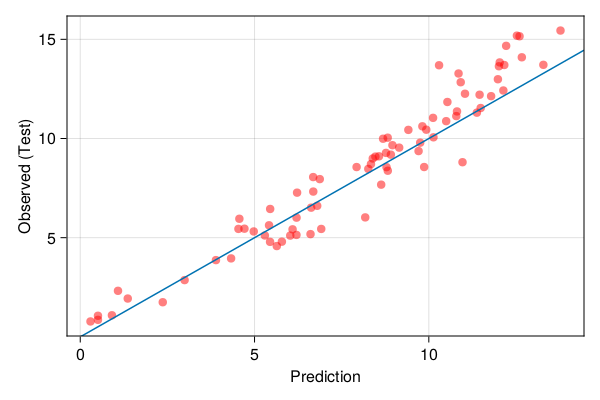

In [29]:
plotxy(vec(pred), ytest; color = (:red, .5),
    bisect = true, xlabel = "Prediction",
    ylabel = "Observed (Test)").f

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*